In [419]:
from category_encoders.ordinal import OrdinalEncoder as oe
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import vtreat
from sklearn.cluster import KMeans

sns.set(style='white')

## Functions

In [448]:
def km_clust_func(df, data, min_clust, max_clust):    
    for cluster in range(min_clust, max_clust + 1):
        km = KMeans(
            n_clusters=cluster,
            init='k-means++',
            algorithm='full',
            max_iter=100,
            random_state=96724)
        km.fit(data)
        df['{}_km_clust'.format(cluster)] = pd.Series(km.labels_)
    data = s.inverse_transform(data)
    hold = pd.DataFrame(data, columns=clust_model_df.columns)
    df = pd.concat([df, hold], axis=1)
    return df

def ms_clust_func(df, data, quantile):
    bandwidth = estimate_bandwidth(data, quantile=quantile, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data)
    df['ms_labels'] = pd.Series(ms.labels_)
    print('Number of clusters generated: {}'.format(df['ms_labels'].nunique()))
    print('Estimated Bandwidth: {}'.format(bandwidth))
    return

## Data Loading

In [480]:
#data is from 2014
data_path = ("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")
df = pd.read_csv(data_path)

In [481]:
df.head()
df.columns

Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k',
       'half', '20k', 'country', 'city', '40k'],
      dtype='object')

## Data Cleaning & Light EDA

In [264]:
#identifying nulls and handling unknowns
#for nm in df.columns:
#    print('{}\n{}\n'.format(nm, df[nm].isna().value_counts()))

impute = df.loc[df.state.isna(), ['ctz', 'city', 'state', 'country']]

df.loc[(df.country == 'USA') & (df.state.isna())]

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k


The city, state, and ctz (citizenship) columns are the only ones with nulls. There isn't a good way to impute the missing values for city, due to it being one person from Brazil and all other location identifiers are null. The state columns null values are all from international cities so I will impute 'non_usa' into the state column. Citizenship nulls are tough, I could impute them to be whatever the country is, but a runner from the USA could have citizenship in any number of countries. So there is no wrong information in the dataset I will classify these as 'unknown'.

In [482]:
##### ONLY RUN THIS ONCE #####
for col in df[['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k']]:
    df.loc[df[col].str.contains('-'), col] = np.nan

In [483]:
#3 types of bibs, F+number, W+number, & number only. Making columns 
#to classify the different types could help clustering
df.loc[:, 'f_bib'] = 0
df.loc[df.bib.str.contains('F'), 'f_bib'] = 1

df.loc[:, 'w_bib'] = 0
df.loc[df.bib.str.contains('W'), 'w_bib'] = 1

mask = (
    (df.bib.str.contains('W')) |
    (df.bib.str.contains('F'))
)
df.loc[:, 'num_bib'] = 0
df.loc[~mask, 'num_bib'] = 1

#cleaning nulls in location columns
df.loc[df.state.isna(), 'state'] = 'non_usa'
df.loc[df.ctz.isna(), 'ctz'] = 'unknown'
df.loc[df.city.isna(), 'city'] = 'unknown'

#converting times to floats 
for col in df[['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k']]:
    df[col] = df[col].astype('float')

#making categorical variables ordinal for clustering 
df['is_male'] = np.where(df['gender'] == 'M', 1, 0)

state_labels, state_uniques = pd.factorize(df['state'])
df['state_id'] = state_labels  

city_labels, city_uniques = pd.factorize(df['city'])
df['city_id'] = city_labels

country_labels, country_uniques = pd.factorize(df['country'])
df['country_id'] = country_labels

ctz_labels, ctz_uniques = pd.factorize(df['ctz'])
df['ctz_id'] = ctz_labels

In [576]:
df.loc[:, 'is_international'] = '1'
df.loc[df.country == 'USA', 'is_international'] = '0'

df.loc[:, 'is_bostonian'] = 0
df.loc[df['city'] == 'Boston', 'is_bostonian'] = 1

df.loc[:, 'is_kenyan'] = 0
df.loc[df['country'] == 'KEN', 'is_kenyan'] = 1

In [539]:
#could the bibs signify some sort of finishing time?
print('Number of W_bibs:\n{}\n'.format(df['w_bib'].value_counts()))
print('Number of F_bibs:\n{}'.format(df['f_bib'].value_counts()))

Number of W_bibs:
0    31931
1       53
Name: w_bib, dtype: int64

Number of F_bibs:
0    31936
1       48
Name: f_bib, dtype: int64


In [269]:
df.overall.max()

31931

## Clustering Run Times

### Data Prep

In [140]:
for col in df[['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k']]:
    print('{} nulls: {}'.format(col, len(df.loc[df[col].isna()])))

5k nulls: 52
10k nulls: 50
20k nulls: 51
half nulls: 72
25k nulls: 216
30k nulls: 40
35k nulls: 34
40k nulls: 39


In [334]:
features = ['5k', '10k', '20k', 'half','25k','30k', '35k', '40k', 'official']
clust_model_df = df.loc[:, features]
clust_model_df.dropna(inplace=True)

#splitting dataset into 4 groups to check for cluster stability
X1, X2 = train_test_split(clust_model_df, test_size=0.5, random_state=654)

#uneven numbers for even split so I am storing the last row to add in after last split
extra_row = X2.iloc[15824:15825]
X2 = X2.iloc[:15824]
X1, X2, X3, X4 = train_test_split(X1, X2, test_size=0.5, random_state=654)

#adding the odd row back into X2 so I don't lose data
X2 = pd.concat([X2, extra_row], axis=0)

print(len(X1))
print(len(X2))
print(len(X3))
print(len(X4))

s = StandardScaler()
X1 = s.fit_transform(X1)
X2 = s.fit_transform(X2)
X3 = s.fit_transform(X3)
X4 = s.fit_transform(X4)

7912
7913
7912
7912


### KMeans on Data subsets

In [354]:
X1_clust = pd.DataFrame()
X2_clust = pd.DataFrame()
X3_clust = pd.DataFrame()
X4_clust = pd.DataFrame()

X1_clust = km_clust_func(X1_clust, X1, 2, 12)
X2_clust = km_clust_func(X2_clust, X2, 2, 12)
X3_clust = km_clust_func(X3_clust, X3, 2, 12)
X4_clust = km_clust_func(X4_clust, X4, 2, 12)

X1_clust.columns

Index(['2_km_clust', '3_km_clust', '4_km_clust', '5_km_clust', '6_km_clust',
       '7_km_clust', '8_km_clust', '9_km_clust', '10_km_clust', '11_km_clust',
       '12_km_clust', '5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k',
       'official', 'pace'],
      dtype='object')

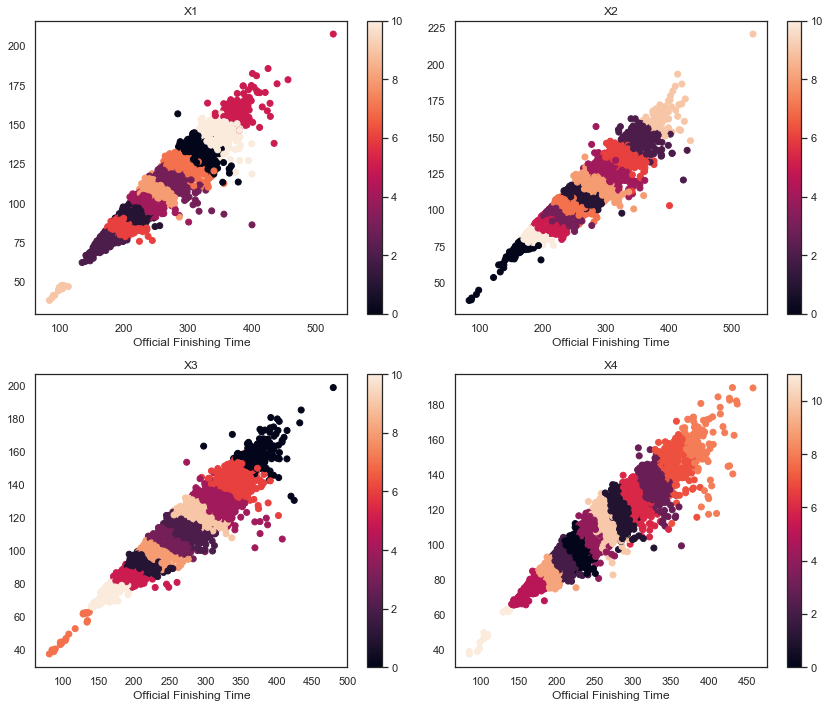

In [385]:
plt.figure(figsize=(12,10))
n=1
for df in [X1_clust, X2_clust, X3_clust, X4_clust]:
    plt.subplot(2,2,n)
    plt.scatter(x=df['official'], y=df['20k'], c=df['11_km_clust'])
    #plt.xlim(33000, -1000)
    plt.xlabel('Official Finishing Time')
    plt.title('X{}'.format(n))
    plt.colorbar()
    n+=1
plt.tight_layout()
plt.show()

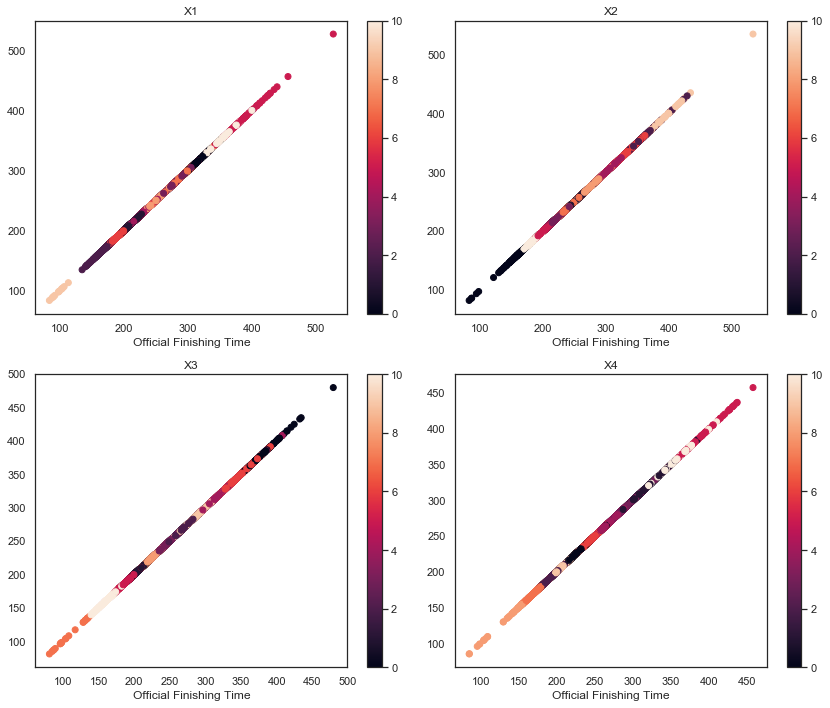

In [375]:
plt.figure(figsize=(12,10))
n=1
for df in [X1_clust, X2_clust, X3_clust, X4_clust]:
    plt.subplot(2,2,n)
    plt.scatter(x=df['official'], y=df['official'], c=df['11_km_clust'])
    #plt.xlim(33000, -1000)
    plt.xlabel('Official Finishing Time')
    plt.title('X{}'.format(n))
    plt.colorbar()
    n+=1
plt.tight_layout()
plt.show()

The 11 cluster solution does two things well that I am looking for. It segments out at close to the same place in all of the clusters and it is able to segment the top performers in regards to finishing time. While this creates a large number of breaks for the rest of the field, I think there will be some interesting statistics that come from those categories considering the categories have a lot of overlap in the finishing time category. From here let's recombine the data and run the clustering for the whole dataset.

In [386]:
#looking for stability with mean finishing time in the groups
n = 0
for data in [X1_clust, X2_clust, X3_clust, X4_clust]:
    n+=1
    print('\nX{}_data\n{}'.format(n, data.groupby('11_km_clust')['half'].mean()))


X1_data
11_km_clust
0     140.222991
1      99.012994
2      81.997083
3     121.417009
4     106.150942
5     168.640348
6      90.739258
7     130.985459
8     114.505814
9      46.380073
10    152.174094
Name: half, dtype: float64

X2_data
11_km_clust
0      77.382989
1     116.571666
2     156.581334
3     102.395314
4     134.772761
5      95.287703
6     144.668213
7     109.262966
8     124.903529
9     172.877426
10     87.958854
Name: half, dtype: float64

X3_data
11_km_clust
0     168.177849
1      98.115179
2     119.906373
3     112.950807
4     137.623770
5      89.842415
6     149.807609
7      53.482763
8     105.125104
9     129.206751
10     80.658301
Name: half, dtype: float64

X4_data
11_km_clust
0     105.028275
1     126.191151
2      98.099650
3     142.831108
4     112.407058
5      81.412242
6     133.962127
7     154.351221
8     167.025556
9      90.424509
10    118.909913
11     52.576875
Name: half, dtype: float64


### KMeans Full Dataset

In [484]:
to_model_df = df.loc[:, features]
to_model_df.dropna(inplace=True)

s.fit_transform(to_model_df)

km = KMeans(
    n_clusters=11,
    init='k-means++',
    algorithm='full',
    max_iter=100,
    random_state=96724)
km.fit(to_model_df)
df['11_km_clust'] = pd.Series(km.labels_)

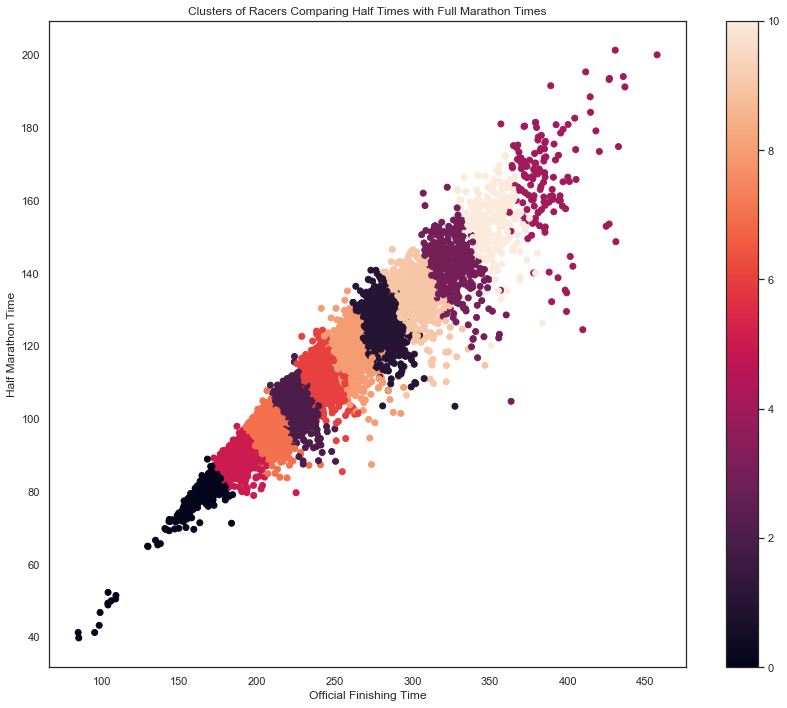

In [394]:
plt.figure(figsize=(12,10))
plt.scatter(x=df['official'], y=df['half'], c=df['11_km_clust'])
plt.xlabel('Official Finishing Time')
plt.ylabel('Half Marathon Time')
plt.title('Clusters of Racers Comparing Half Times with Full Marathon Times')
plt.colorbar()
plt.tight_layout()
plt.show()

Alright, the final clustering did not break out the leader group as much as I would have hoped. Regardless this was the best of the potential clusters from the earlier analysis. Let's take a look at how the different categories are broken out within the categories.

### Mean Shift on Data Subsets

In [423]:
bandwidth = estimate_bandwidth(X1, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X1)
X1_clust['ms_labels'] = pd.Series(ms.labels_)
print('Number of clusters generated: {}'.format(X1_clust['ms_labels'].nunique()))
print('Estimated Bandwidth: {}'.format(bandwidth))

Number of clusters generated: 8
Estimated Bandwidth: 1.53676213699547


In [453]:
ms_clust_func(X1_clust, X1, 0.2)
ms_clust_func(X2_clust, X2, 0.2)
ms_clust_func(X3_clust, X3, 0.2)
ms_clust_func(X4_clust, X4, 0.2)

Number of clusters generated: 8
Estimated Bandwidth: 1.53676213699547
Number of clusters generated: 10
Estimated Bandwidth: 1.6058127905340724
Number of clusters generated: 6
Estimated Bandwidth: 1.5513472793404863
Number of clusters generated: 7
Estimated Bandwidth: 1.5517614807524696


The estimated bandwidths are similar for the subsets of the main df, but the number of clusters generated is quite different. With mean shift, the end results consistemcy will be important, but it wont be the only factor given how differently this algorithm is from kmeans.

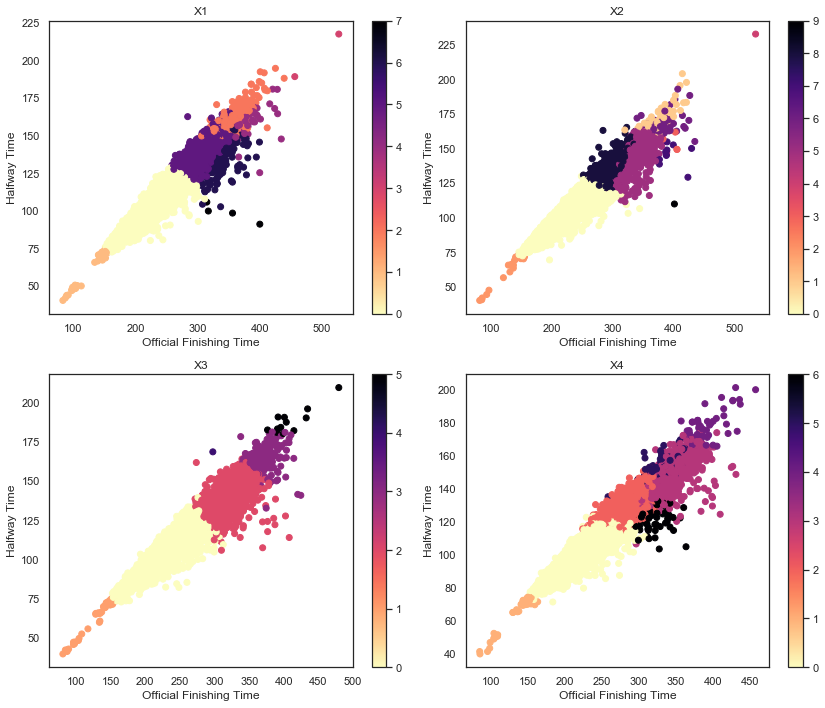

In [454]:
plt.figure(figsize=(12,10))
n=1
for df in [X1_clust, X2_clust, X3_clust, X4_clust]:
    plt.subplot(2,2,n)
    plt.scatter(x=df['official'], y=df['half'], c=df['ms_labels'], cmap='magma_r')
    plt.ylabel('Halfway Time')
    plt.xlabel('Official Finishing Time')
    plt.title('X{}'.format(n))
    plt.colorbar()
    n+=1
plt.tight_layout()
plt.show()

The mean shift clustering method provides some inconsistencies from group to group, but it does a much better job of identifying the top runners than the KMeans algorithm does. It also seems to capture a group of runners that seem to have outperformed during the first half of the race in comparison to their finishing time. Even though the consistency isn't as clean as kmeans, I still want to try this method on the full dataset

### Mean Shift on Full Dataset

In [466]:
to_model_df.columns

Index(['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official',
       'pace'],
      dtype='object')

In [474]:
#bandwidth = estimate_bandwidth(to_model_df, quantile=0.1, n_samples=1000)
ms = MeanShift(bandwidth=50, bin_seeding=True)
ms.fit(to_model_df)
df['ms_labels'] = pd.Series(ms.labels_)
print('Number of clusters generated: {}'.format(df['ms_labels'].nunique()))
#print('Estimated Bandwidth: {}'.format(bandwidth))

Number of clusters generated: 6


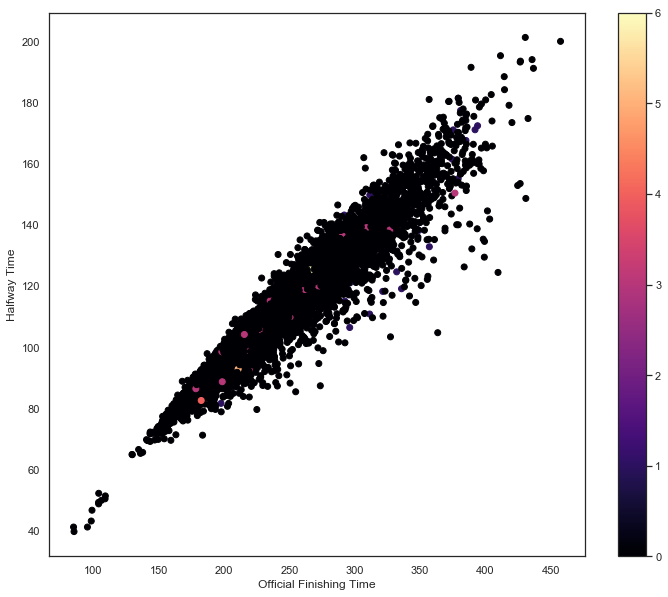

In [477]:
plt.figure(figsize=(12,10))
plt.scatter(x=df['official'], y=df['half'], c=df['ms_labels'], cmap='magma')
plt.ylabel('Halfway Time')
plt.xlabel('Official Finishing Time')
plt.colorbar()
plt.show()

Given the density of the data, I think the mean shift algorithm is having a hard time breaking out any meaningful clusters. The clusters that were identified in the subsets of data were likely artifical due to the smaller number of datapoints available.

Considering the poor clustering ability with the full dataset I think KMeans is my best bet for this dataset.

## What Do The Clusters Mean?

In [532]:
df['11_km_clust'] = df['11_km_clust'].astype('float')
    
for clst in df['11_km_clust'].unique():
    print('Cluster {} Average Finishing Time: {}'.format(clst, df.loc[df['11_km_clust'] == clst, 'official'].mean()))

for clst in df['11_km_clust'].unique():    
    print('Cluster {} Top States:\n{}\n'.format(clst, df.loc[df['11_km_clust'] == clst, 'state'].value_counts()))

Cluster 9.0 Average Finishing Time: 159.649735099338
Cluster 3.0 Average Finishing Time: 189.70945222929956
Cluster 8.0 Average Finishing Time: 205.61431094527333
Cluster 1.0 Average Finishing Time: 223.17478668261535
Cluster 0.0 Average Finishing Time: 293.74391566265086
Cluster 5.0 Average Finishing Time: 239.4219295958286
Cluster 4.0 Average Finishing Time: 257.2398363636362
Cluster 2.0 Average Finishing Time: 272.38958654736183
Cluster 10.0 Average Finishing Time: 285.30771323529456
Cluster 6.0 Average Finishing Time: 291.1626442762535
Cluster 7.0 Average Finishing Time: 294.68489239598273
Cluster nan Average Finishing Time: nan
Cluster 9.0 Top States:
MA         88
non_usa    87
CA         64
NY         41
IL         41
CO         34
VA         25
PA         24
WA         23
MI         21
TX         19
NC         18
OH         18
OR         16
ON         16
MD         15
WI         14
NJ         14
MN         13
AZ         13
QC         12
ME         11
FL         10
IN          9

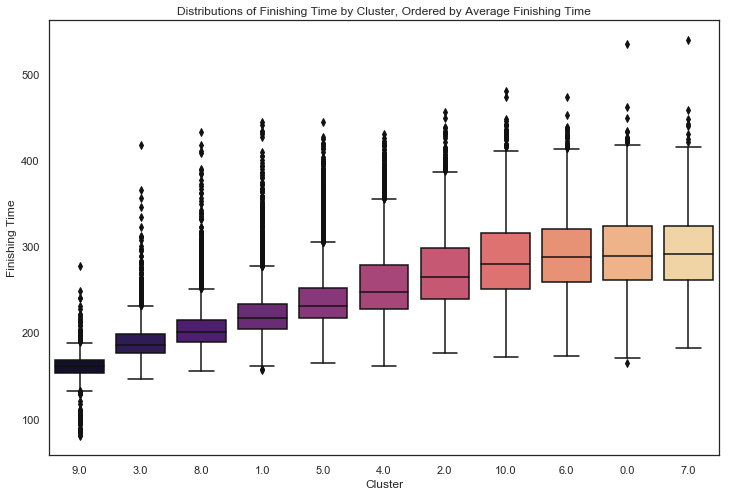

In [531]:
plt.figure(figsize=(12,8))
clust_group = df.groupby('11_km_clust')['official'].aggregate(np.mean).sort_values()
sns.boxplot(
    df['11_km_clust'],
    df['official'],
    order = clust_group.index,
    palette='magma'
)
plt.xlabel('Cluster')
plt.ylabel('Finishing Time')
plt.title('Distributions of Finishing Time by Cluster, Ordered by Average Finishing Time')
plt.show()

Cluster 9 is by far the fastest group of runners! let's figure out what makes that group so much different than the rest of the field. Their average finishing time is 2:39 which is blistering fast considering the world record holder has a time of 2:01.39. Maybe this group holds the key to unraveling the w_bib and f_bib mysteries.

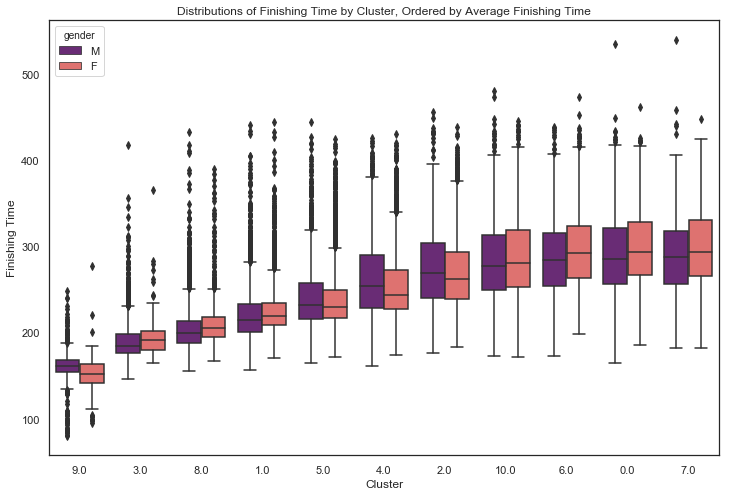

In [541]:
plt.figure(figsize=(12,8))
clust_group = df.groupby('11_km_clust')['official'].aggregate(np.mean).sort_values()
sns.boxplot(
    df['11_km_clust'],
    df['official'],
    order = clust_group.index,
    hue=df['gender'],
    palette='magma'
)
plt.xlabel('Cluster')
plt.ylabel('Finishing Time')
plt.title('Distributions of Finishing Time by Cluster, Ordered by Average Finishing Time')
plt.show()

In [536]:
print('Cluster 9 Gender Counts:\n{}\n'.format(df.loc[df['11_km_clust'] == 9.0, 'gender'].value_counts()))
print('Cluster 3 Gender Counts:\n{}\n'.format(df.loc[df['11_km_clust'] == 3.0, 'gender'].value_counts()))
print('Cluster 7 Gender Counts:\n{}'.format(df.loc[df['11_km_clust'] == 7.0, 'gender'].value_counts()))

Cluster 9 Gender Counts:
M    700
F     55
Name: gender, dtype: int64

Cluster 3 Gender Counts:
M    2919
F     221
Name: gender, dtype: int64

Cluster 7 Gender Counts:
M    349
F    348
Name: gender, dtype: int64


Well, there is one difference from the top clusters to the bottom, they are primarily made up of men. However, that is in no way the whole story. While the fastest times in cluster 9 do go to men, the women are right behind them. Also, the median finishing time for the female runners is actually faster than the male runner. Cluster 7 is almost evenly split between the genders with quite a lot of overlap in finishing times with clusters 9 & 3. Now, about those bibs...

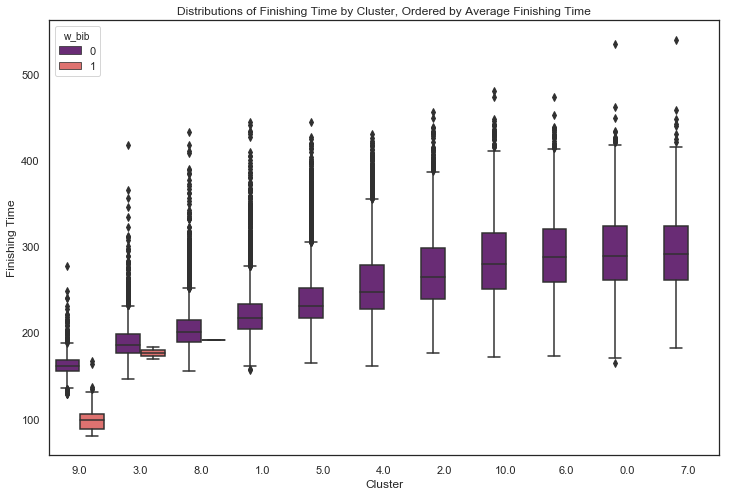

In [542]:
plt.figure(figsize=(12,8))
clust_group = df.groupby('11_km_clust')['official'].aggregate(np.mean).sort_values()
sns.boxplot(
    df['11_km_clust'],
    df['official'],
    order = clust_group.index,
    hue=df['w_bib'],
    palette='magma'
)
plt.xlabel('Cluster')
plt.ylabel('Finishing Time')
plt.title('Distributions of Finishing Time by Cluster, Ordered by Average Finishing Time')
plt.show()

In [537]:
print('Cluster 9 W_bib Counts:\n{}\n'.format(df.loc[df['11_km_clust'] == 9.0, 'w_bib'].value_counts()))
print('Cluster 3 W_bib Counts:\n{}\n'.format(df.loc[df['11_km_clust'] == 3.0, 'w_bib'].value_counts()))
print('Cluster 7 W_bib Counts:\n{}'.format(df.loc[df['11_km_clust'] == 7.0, 'w_bib'].value_counts()))

Cluster 9 W_bib Counts:
0    705
1     50
Name: w_bib, dtype: int64

Cluster 3 W_bib Counts:
0    3138
1       2
Name: w_bib, dtype: int64

Cluster 7 W_bib Counts:
0    697
Name: w_bib, dtype: int64


Here is where things start to become clear. The w_bib holders are world record breaking fast, like finish in less than 2 hours fast, which has never been done by a runner. I think the w_bib holders might have a different way of competing in the marathon. After doing some more research, it turns out that the w_bib holders are wheelchair participants with racing wheelchairs. The fastest recorded wheelchair time for the Boston Marathon was in 2012 with a time of 1:18.25. What else could be different with out clusters?

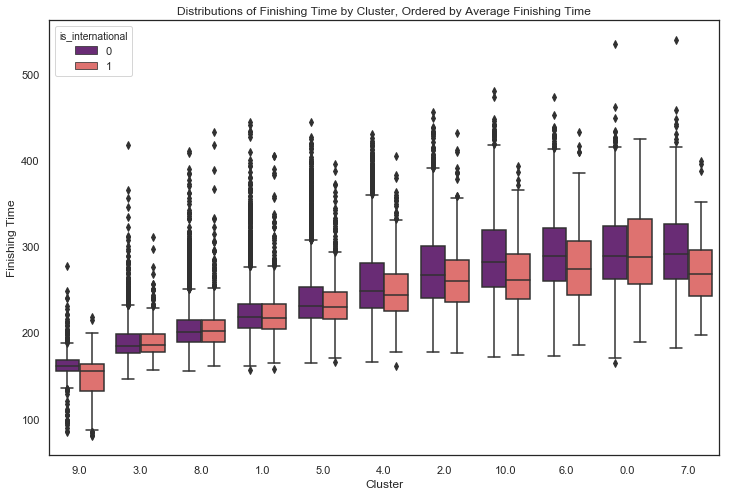

In [545]:
plt.figure(figsize=(12,8))
clust_group = df.groupby('11_km_clust')['official'].aggregate(np.mean).sort_values()
sns.boxplot(
    df['11_km_clust'],
    df['official'],
    order = clust_group.index,
    hue=df['is_international'],
    palette='magma'
)
plt.xlabel('Cluster')
plt.ylabel('Finishing Time')
plt.title('Distributions of Finishing Time by Cluster, Ordered by Average Finishing Time')
plt.show()

In [547]:
print('Total International Participants:\n{}\n'.format(df['is_international'].value_counts()))
print('Cluster 9 International Competitors:\n{}\n'.format(df.loc[df['11_km_clust'] == 9.0, 'is_international'].value_counts()))
print('Cluster 3 International Competitors:\n{}\n'.format(df.loc[df['11_km_clust'] == 3.0, 'is_international'].value_counts()))
print('Cluster 7 International Competitors:\n{}'.format(df.loc[df['11_km_clust'] == 7.0, 'is_international'].value_counts()))

Total International Participants:
0    27233
1     4751
Name: is_international, dtype: int64

Cluster 9 International Competitors:
0    634
1    121
Name: is_international, dtype: int64

Cluster 3 International Competitors:
0    2572
1     568
Name: is_international, dtype: int64

Cluster 7 International Competitors:
0    645
1     52
Name: is_international, dtype: int64


Most of the competitors overall are from the U.S. and their finishing times seem to be pretty comparable to the international competitors in all of the clusters. So most of the competitors are from the U.S., but do any of the clusters identify the Bostonians?

In [564]:
print('Total Bostonian Participants:\n{}\n'.format(df['is_bostonian'].value_counts()))
print('Cluster 9 Bostonian Competitors:\n{}\n'.format(df.loc[df['11_km_clust'] == 9.0, 'is_bostonian'].value_counts()))
print('Cluster 3 Bostonian Competitors:\n{}\n'.format(df.loc[df['11_km_clust'] == 3.0, 'is_bostonian'].value_counts()))
print('Cluster 8 Bostonian Competitors:\n{}\n'.format(df.loc[df['11_km_clust'] == 8.0, 'is_bostonian'].value_counts()))
print('Cluster 7 Bostonian Competitors:\n{}'.format(df.loc[df['11_km_clust'] == 7.0, 'is_bostonian'].value_counts()))

Total Bostonian Participants:
0    30950
1     1034
Name: is_bostonian, dtype: int64

Cluster 9 Bostonian Competitors:
0    742
1     13
Name: is_bostonian, dtype: int64

Cluster 3 Bostonian Competitors:
0    3112
1      28
Name: is_bostonian, dtype: int64

Cluster 8 Bostonian Competitors:
0    3977
1      43
Name: is_bostonian, dtype: int64

Cluster 7 Bostonian Competitors:
0    642
1     55
Name: is_bostonian, dtype: int64


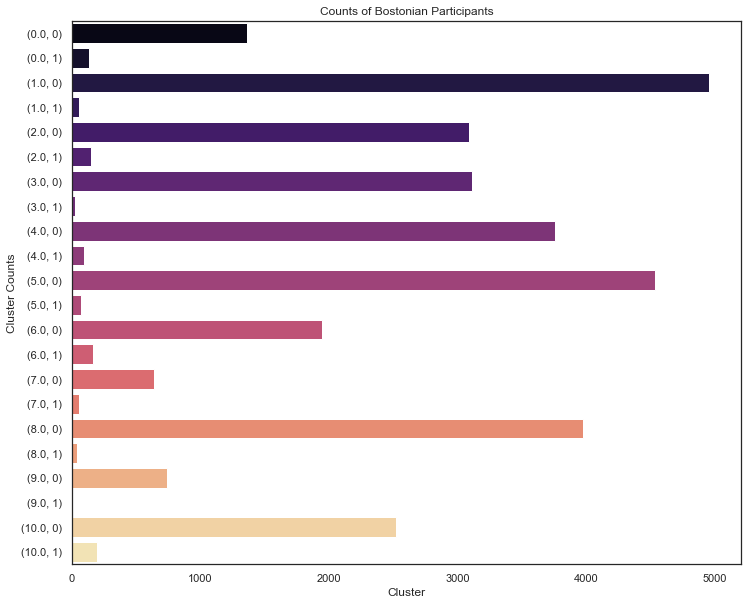

In [572]:
plt.figure(figsize=(12,10))
bost_clust = df.groupby('11_km_clust')
clust_group = df.groupby('11_km_clust')['official'].aggregate(np.mean).sort_values()
sns.barplot(
    bost_clust['is_bostonian'].value_counts(),
    bost_clust['is_bostonian'].value_counts().index,
    #order = clust_group.index,
    #hue=df['is_bostonian'],
    palette='magma'
)
plt.xlabel('Cluster')
plt.ylabel('Cluster Counts')
plt.title('Counts of Bostonian Participants')
plt.show()

It looks like the Bostonians are fairly well spread out across the groups and don't seem to be identified by one specific cluster. The last thing I want to see if the clusters identified is whether the runner is Kenyan or not. Kenyan and Ethiopian runners dominate the top end of the marathon running world. Let's see if that holds true with this model that is purely based off running times.

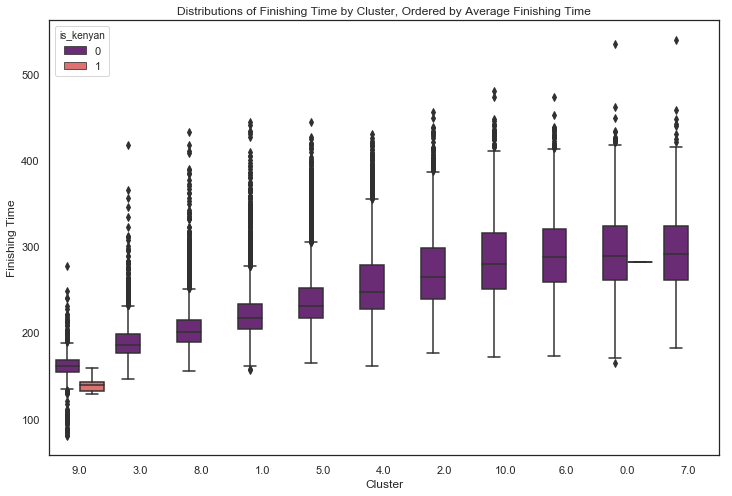

In [577]:
plt.figure(figsize=(12,8))
clust_group = df.groupby('11_km_clust')['official'].aggregate(np.mean).sort_values()
sns.boxplot(
    df['11_km_clust'],
    df['official'],
    order = clust_group.index,
    hue=df['is_kenyan'],
    palette='magma'
)
plt.xlabel('Cluster')
plt.ylabel('Finishing Time')
plt.title('Distributions of Finishing Time by Cluster, Ordered by Average Finishing Time')
plt.show()

It definitely holds true, the Kenyan athletes are all located in cluster 9 of the model (except for one runner in cluster 0).

## Conclusions

So far clustering running times alone has only provided a few insights into the Boston Marathon. For one, the top times are composed of mostly men, the wheelchair racers, and Kenyan athletes. The other categories that were investigated seem to be evenly distributed across all of the clusters.